# Stress test for the maximum number of modalities ICK can handle

## Generate synthetic data in the same say as given in the tutorial

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from collections import defaultdict
from tqdm.notebook import trange
sys.path.insert(0, '../../')
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.metrics import mean_squared_error, mean_absolute_error

from kernels.nystrom import ImplicitNystromKernel
from kernels.nn import ImplicitDenseNetKernel
from kernels.bnn import ImplicitDenseBayesNetKernel
from kernels.kernel_fn import *
from model.ick import ICK
from utils.train import Trainer, VariationalBayesTrainer, EnsembleTrainer
from utils.helpers import *

import torch
from torch import optim
from gpytorch.kernels import LinearKernel, SpectralMixtureKernel
from gpytorch.kernels import PeriodicKernel, RBFKernel, MaternKernel, ScaleKernel
from torch.distributions.multivariate_normal import MultivariateNormal

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True

/Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Number of modalities = 1

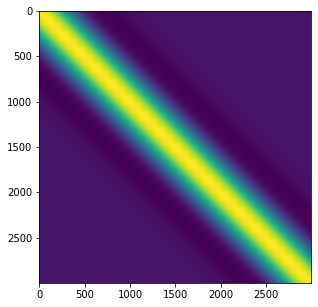

In [2]:
# Calculate the covariance matrix for spectral mixture kernel
fig, ax = plt.subplots(1,1,figsize=(5,5))
N = 3000
x = torch.linspace(0,2,N).reshape(-1,1)
cov_module = SpectralMixtureKernel(num_mixtures=2)
cov_sm = cov_module(x).evaluate().detach()
ax.imshow(cov_sm)
cov = cov_sm + torch.eye(cov_sm.shape[0])*1e-3

In [3]:
# Generate data points from GP with the multiplicative kernel
mv_normal_mul = MultivariateNormal(loc=torch.zeros(N),covariance_matrix=cov)
y = mv_normal_mul.sample()
data, target = [x.numpy()], y.numpy()
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, target, shuffle_data=True, random_seed=2020)
# Note that when creating generators, the validation set is optional and the order of the function
# arguments is train -> test -> val
data_generators = create_generators_from_data(x_train, y_train, x_test, y_test, x_val, y_val)

In [4]:
# Construct kernels
kernel_assignment = ['ImplicitNystromKernel']
kernel_params = {
    'ImplicitNystromKernel': {
        'kernel_func': spectral_mixture_kernel_1d_nys, 
        'params': ['weight','mean','cov','noise'], 
        'vals': [[1.0,0.0],[0.0,0.0], [0.5,0.5], 0.1], 
        'trainable': [True,True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 16, 
        'nys_space': [[0.,2.]]
    }
}

In [ ]:
# Training and evaluation
model = ICK(kernel_assignment, kernel_params)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 1e-4, 
    'momentum': 0.99, 
    'weight_decay': 0.0
}
epochs, patience = 1000, 10
trainer = Trainer(
    model=model,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience
)
trainer.train()

In [6]:
y_test_pred, y_test_true = trainer.predict()
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test_true, y_test_pred))))
print("MAE: {}".format(mean_absolute_error(y_test_true, y_test_pred)))

RMSE: 0.033396847546100616
MAE: 0.026585064828395844


## Number of modalities = 2

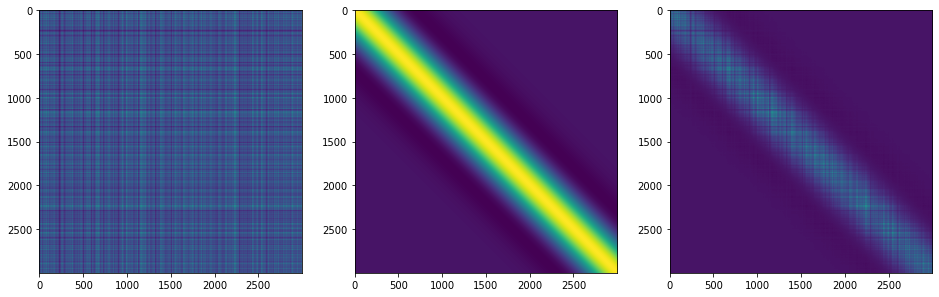

In [7]:
# Calculate the covariance matrix for linear kernel
fig, axs = plt.subplots(1,3,figsize=(16,7))
N = 3000
x = torch.rand(N,1)
cov_module = LinearKernel()
cov_lin = cov_module(x).evaluate().detach()
axs[0].imshow(cov_lin)
# Calculate the covariance matrix for spectral mixture kernel
t = torch.linspace(0,2,N).reshape(-1,1)
cov_module = SpectralMixtureKernel(num_mixtures=2)
cov_sm = cov_module(t).evaluate().detach()
axs[1].imshow(cov_sm)
cov = cov_lin*cov_sm + torch.eye(cov_lin.shape[0])*1e-3
axs[2].imshow(cov)

In [8]:
# Generate data points from GP with the multiplicative kernel
mv_normal_mul = MultivariateNormal(loc=torch.zeros(N),covariance_matrix=cov)
y = mv_normal_mul.sample()
rt_model = RandomTreesEmbedding(n_estimators=10, max_depth=2, random_state=42)
x_transformed = torch.tensor(rt_model.fit_transform(np.array(x).reshape(-1,1)).toarray())
data, target = [x_transformed.numpy(), t.numpy()], y.numpy()
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, target, shuffle_data=True, random_seed=2020)
# Note that when creating generators, the validation set is optional and the order of the function
# arguments is train -> test -> val
data_generators = create_generators_from_data(x_train, y_train, x_test, y_test, x_val, y_val)

In [9]:
# Construct kernels
kernel_assignment = ['ImplicitDenseNetKernel', 'ImplicitNystromKernel']
kernel_params = {
    'ImplicitDenseNetKernel':{
        'input_dim': 40,
        'latent_feature_dim': 16,
        'num_blocks': 1, 
        'num_layers_per_block': 1, 
        'num_units': 64
    }, 
    'ImplicitNystromKernel': {
        'kernel_func': spectral_mixture_kernel_1d_nys, 
        'params': ['weight','mean','cov','noise'], 
        'vals': [[1.0,0.0],[0.0,0.0], [0.5,0.5], 0.1], 
        'trainable': [True,True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 16, 
        'nys_space': [[0.,2.]]
    }
}

In [ ]:
# Training and evaluation
model = ICK(kernel_assignment, kernel_params)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 5e-5, 
    'momentum': 0.99, 
    'weight_decay': 0.0
}
epochs, patience = 1000, 10
trainer = Trainer(
    model=model,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience
)
trainer.train()

In [11]:
y_test_pred, y_test_true = trainer.predict()
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test_true, y_test_pred))))
print("MAE: {}".format(mean_absolute_error(y_test_true, y_test_pred)))

RMSE: 0.04400957003235817
MAE: 0.03466659411787987


## Number of modalities = 3

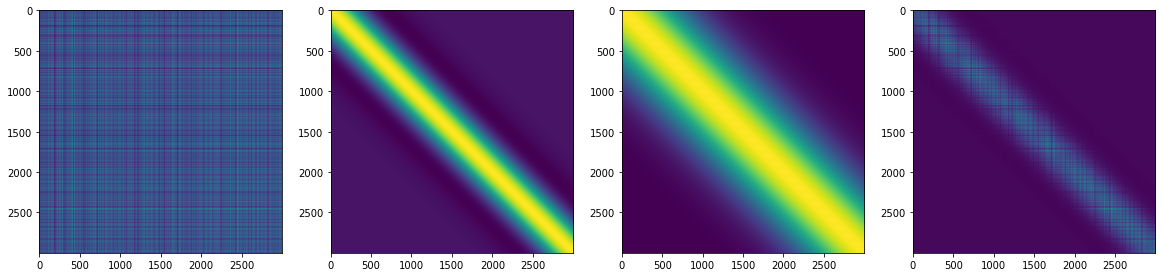

In [12]:
# Calculate the covariance matrix for linear kernel
fig, axs = plt.subplots(1,4,figsize=(20,8))
N = 3000
x1 = torch.rand(N,1)
cov_module = LinearKernel()
cov_lin = cov_module(x1).evaluate().detach()
axs[0].imshow(cov_lin)
# Calculate the covariance matrix for spectral mixture kernel
x2 = torch.linspace(0,2,N).reshape(-1,1)
cov_module = SpectralMixtureKernel(num_mixtures=2)
cov_sm = cov_module(x2).evaluate().detach()
axs[1].imshow(cov_sm)
# Calculate the covariance matrix for RBF kernel
x3 = torch.linspace(0,4,N).reshape(-1,1)
cov_module = ScaleKernel(RBFKernel())
cov_rbf = cov_module(x3).evaluate().detach()
axs[2].imshow(cov_rbf)
cov = cov_lin*cov_sm*cov_rbf + torch.eye(cov_lin.shape[0])*1e-3
axs[3].imshow(cov)

In [13]:
# Generate data points from GP with the multiplicative kernel
mv_normal_mul = MultivariateNormal(loc=torch.zeros(N),covariance_matrix=cov)
y = mv_normal_mul.sample()
rt_model = RandomTreesEmbedding(n_estimators=10, max_depth=2, random_state=42)
x1_transformed = torch.tensor(rt_model.fit_transform(np.array(x1).reshape(-1,1)).toarray())
data, target = [x1_transformed.numpy(), x2.numpy(), x3.numpy()], y.numpy()
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, target, shuffle_data=True, random_seed=2020)
# Note that when creating generators, the validation set is optional and the order of the function
# arguments is train -> test -> val
data_generators = create_generators_from_data(x_train, y_train, x_test, y_test, x_val, y_val)

In [14]:
# Construct kernels
kernel_assignment = ['ImplicitDenseNetKernel', 'ImplicitNystromKernel', 'ImplicitNystromKernel']
kernel_params = {
    'ImplicitDenseNetKernel':{
        'input_dim': 40,
        'latent_feature_dim': 16,
        'num_blocks': 1, 
        'num_layers_per_block': 1, 
        'num_units': 64
    }, 
    'ImplicitNystromKernel': {
        'kernel_func': spectral_mixture_kernel_1d_nys, 
        'params': ['weight','mean','cov','noise'], 
        'vals': [[1.0,0.0],[0.0,0.0], [0.5,0.5], 0.1], 
        'trainable': [True,True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 16, 
        'nys_space': [[0.,2.]]
    }, 
    'ImplicitNystromKernel': {
        'kernel_func': sq_exp_kernel_nys, 
        'params': ['std','lengthscale','noise'], 
        'vals': [1.,0.5,0.1], 
        'trainable': [True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 16, 
        'nys_space': [[0.,4.]]
    }
}

In [ ]:
# Training and evaluation
model = ICK(kernel_assignment, kernel_params)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 1e-4, 
    'momentum': 0.99, 
    'weight_decay': 0.0
}
epochs, patience = 1000, 10
trainer = Trainer(
    model=model,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience
)
trainer.train()

In [16]:
y_test_pred, y_test_true = trainer.predict()
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test_true, y_test_pred))))
print("MAE: {}".format(mean_absolute_error(y_test_true, y_test_pred)))

RMSE: 0.04657917842268944
MAE: 0.03525613248348236


## Number of modalities = 4

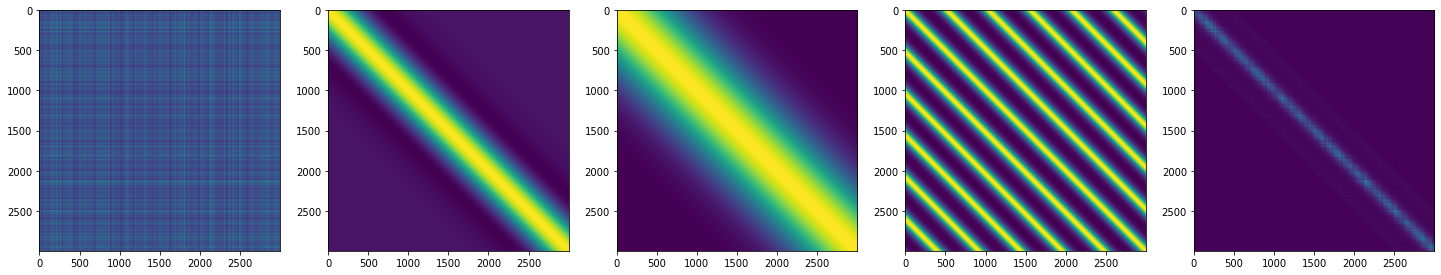

In [17]:
# Calculate the covariance matrix for linear kernel
fig, axs = plt.subplots(1,5,figsize=(25,10))
N = 3000
x1 = torch.rand(N,1)
cov_module = LinearKernel()
cov_lin = cov_module(x1).evaluate().detach()
axs[0].imshow(cov_lin)
# Calculate the covariance matrix for spectral mixture kernel
x2 = torch.linspace(0,2,N).reshape(-1,1)
cov_module = SpectralMixtureKernel(num_mixtures=2)
cov_sm = cov_module(x2).evaluate().detach()
axs[1].imshow(cov_sm)
# Calculate the covariance matrix for RBF kernel
x3 = torch.linspace(0,4,N).reshape(-1,1)
cov_module = ScaleKernel(RBFKernel())
cov_rbf = cov_module(x3).evaluate().detach()
axs[2].imshow(cov_rbf)
# Calculate the covariance matrix for exponential sine-squared kernel
x4 = torch.linspace(0,4,N).reshape(-1,1)
cov_module = ScaleKernel(PeriodicKernel())
cov_per = cov_module(x4).evaluate().detach()
axs[3].imshow(cov_per)
cov = cov_lin*cov_sm*cov_rbf*cov_per + torch.eye(cov_lin.shape[0])*1e-3
axs[4].imshow(cov)

In [18]:
# Generate data points from GP with the multiplicative kernel
mv_normal_mul = MultivariateNormal(loc=torch.zeros(N),covariance_matrix=cov)
y = mv_normal_mul.sample()
rt_model = RandomTreesEmbedding(n_estimators=10, max_depth=2, random_state=42)
x1_transformed = torch.tensor(rt_model.fit_transform(np.array(x1).reshape(-1,1)).toarray())
data, target = [x1_transformed.numpy(), x2.numpy(), x3.numpy(), x4.numpy()], y.numpy()
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, target, shuffle_data=True, random_seed=2020)
# Note that when creating generators, the validation set is optional and the order of the function
# arguments is train -> test -> val
data_generators = create_generators_from_data(x_train, y_train, x_test, y_test, x_val, y_val)

In [19]:
# Construct kernels
kernel_assignment = ['ImplicitDenseNetKernel', 'ImplicitNystromKernel', 
                     'ImplicitNystromKernel', 'ImplicitNystromKernel']
kernel_params = {
    'ImplicitDenseNetKernel':{
        'input_dim': 40,
        'latent_feature_dim': 16,
        'num_blocks': 1, 
        'num_layers_per_block': 1, 
        'num_units': 64
    }, 
    'ImplicitNystromKernel': {
        'kernel_func': spectral_mixture_kernel_1d_nys, 
        'params': ['weight','mean','cov','noise'], 
        'vals': [[1.0,0.0],[0.0,0.0], [0.5,0.5], 0.1], 
        'trainable': [True,True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 16, 
        'nys_space': [[0.,2.]]
    }, 
    'ImplicitNystromKernel': {
        'kernel_func': sq_exp_kernel_nys, 
        'params': ['std','lengthscale','noise'], 
        'vals': [1.,0.5,0.1], 
        'trainable': [True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 16, 
        'nys_space': [[0.,4.]]
    }, 
    'ImplicitNystromKernel': {
        'kernel_func': periodic_kernel_nys, 
        'params': ['std','period','lengthscale','noise'], 
        'vals': [1.,0.25,0.5,0.1], 
        'trainable': [True,True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 16, 
        'nys_space': [[0.,4.]]
    }
}

In [ ]:
# Training and evaluation
model = ICK(kernel_assignment, kernel_params)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 3e-4, 
    'momentum': 0.99, 
    'weight_decay': 0.0
}
epochs, patience = 1000, 10
trainer = Trainer(
    model=model,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience
)
trainer.train()

In [21]:
y_test_pred, y_test_true = trainer.predict()
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test_true, y_test_pred))))
print("MAE: {}".format(mean_absolute_error(y_test_true, y_test_pred)))

RMSE: 0.21080216765403748
MAE: 0.15650606155395508


## Number of modalities = 5

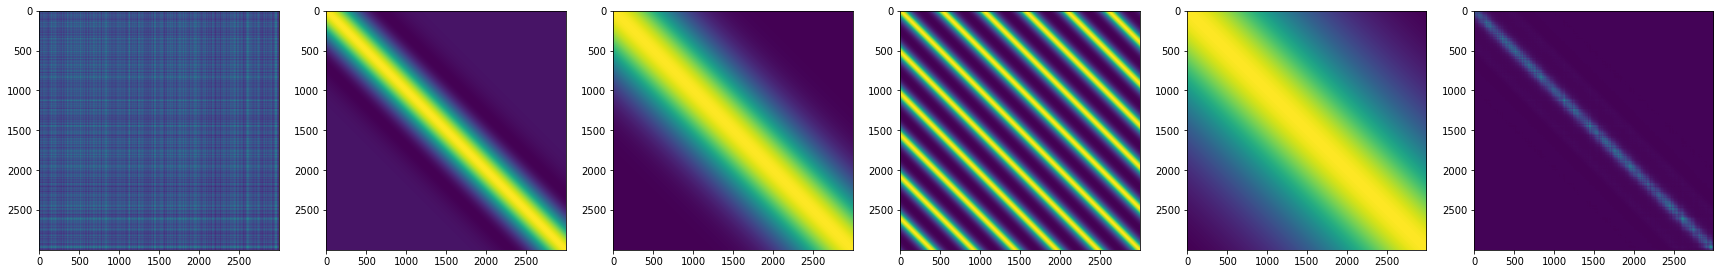

In [22]:
# Calculate the covariance matrix for linear kernel
fig, axs = plt.subplots(1,6,figsize=(30,10))
N = 3000
x1 = torch.rand(N,1)
cov_module = LinearKernel()
cov_lin = cov_module(x1).evaluate().detach()
axs[0].imshow(cov_lin)
# Calculate the covariance matrix for spectral mixture kernel
x2 = torch.linspace(0,2,N).reshape(-1,1)
cov_module = SpectralMixtureKernel(num_mixtures=2)
cov_sm = cov_module(x2).evaluate().detach()
axs[1].imshow(cov_sm)
# Calculate the covariance matrix for RBF kernel
x3 = torch.linspace(0,4,N).reshape(-1,1)
cov_module = ScaleKernel(RBFKernel())
cov_rbf = cov_module(x3).evaluate().detach()
axs[2].imshow(cov_rbf)
# Calculate the covariance matrix for exponential sine-squared kernel
x4 = torch.linspace(0,4,N).reshape(-1,1)
cov_module = ScaleKernel(PeriodicKernel())
cov_per = cov_module(x4).evaluate().detach()
axs[3].imshow(cov_per)
# Calculate the covariance matrix for Matern kernel
x5 = torch.linspace(0,2,N).reshape(-1,1)
cov_module = ScaleKernel(MaternKernel())
cov_rq = cov_module(x5).evaluate().detach()
axs[4].imshow(cov_rq)
cov = cov_lin*cov_sm*cov_rbf*cov_per*cov_rq + torch.eye(cov_lin.shape[0])*1e-3
axs[5].imshow(cov)

In [23]:
# Generate data points from GP with the multiplicative kernel
mv_normal_mul = MultivariateNormal(loc=torch.zeros(N),covariance_matrix=cov)
y = mv_normal_mul.sample()
rt_model = RandomTreesEmbedding(n_estimators=10, max_depth=2, random_state=42)
x1_transformed = torch.tensor(rt_model.fit_transform(np.array(x1).reshape(-1,1)).toarray())
data, target = [x1_transformed.numpy(), x2.numpy(), x3.numpy(), x4.numpy(), x5.numpy()], y.numpy()
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, target, shuffle_data=True, random_seed=2020)
# Note that when creating generators, the validation set is optional and the order of the function
# arguments is train -> test -> val
data_generators = create_generators_from_data(x_train, y_train, x_test, y_test, x_val, y_val)

In [24]:
# Construct kernels
kernel_assignment = ['ImplicitDenseNetKernel', 'ImplicitNystromKernel', 'ImplicitNystromKernel', 
                     'ImplicitNystromKernel', 'ImplicitNystromKernel']
kernel_params = {
    'ImplicitDenseNetKernel':{
        'input_dim': 40,
        'latent_feature_dim': 16,
        'num_blocks': 1, 
        'num_layers_per_block': 1, 
        'num_units': 64
    }, 
    'ImplicitNystromKernel': {
        'kernel_func': spectral_mixture_kernel_1d_nys, 
        'params': ['weight','mean','cov','noise'], 
        'vals': [[1.0,0.0],[0.0,0.0], [0.5,0.5], 0.1], 
        'trainable': [True,True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 16, 
        'nys_space': [[0.,2.]]
    }, 
    'ImplicitNystromKernel': {
        'kernel_func': sq_exp_kernel_nys, 
        'params': ['std','lengthscale','noise'], 
        'vals': [1.,0.5,0.1], 
        'trainable': [True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 16, 
        'nys_space': [[0.,4.]]
    }, 
    'ImplicitNystromKernel': {
        'kernel_func': periodic_kernel_nys, 
        'params': ['std','period','lengthscale','noise'], 
        'vals': [1.,0.25,0.5,0.1], 
        'trainable': [True,True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 16, 
        'nys_space': [[0.,4.]]
    }, 
    'ImplicitNystromKernel': {
        'kernel_func': matern_type2_kernel_nys, 
        'params': ['std','lengthscale','noise'], 
        'vals': [1.,0.5,0.1], 
        'trainable': [True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 16, 
        'nys_space': [[0.,2.]]
    }
}

In [ ]:
# Training and evaluation
model = ICK(kernel_assignment, kernel_params)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 5e-4, 
    'momentum': 0.99, 
    'weight_decay': 0.0
}
epochs, patience = 1000, 10
trainer = Trainer(
    model=model,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience
)
trainer.train()

In [26]:
y_test_pred, y_test_true = trainer.predict()
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test_true, y_test_pred))))
print("MAE: {}".format(mean_absolute_error(y_test_true, y_test_pred)))

RMSE: 0.25596117973327637
MAE: 0.1790279895067215
